In [1]:
import os
import math
import time
import argparse
from tqdm import tqdm

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as d
from classifier.AttributeClassifier import AttributeClassifier
from classifier.LargeScaleAttributesDataset import LargeScaleAttributesDataset
import classifier.utils as u
from torchvision import transforms
from torchsummary import summary
from classifier.Predictor import AttributeClassifierInference
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_root = '../data/largescale/'
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])

In [3]:
tf = transforms.Compose([ transforms.RandomResizedCrop(229), transforms.RandomHorizontalFlip(), transforms.ToTensor(), normalize ])
full_dataset = LargeScaleAttributesDataset( attributes_file=os.path.join(dataset_root, 'LAD_annotations/attributes.txt'),
                                            attributes_list=os.path.join(dataset_root, 'LAD_annotations/attribute_list.txt'),
                                            label_list= os.path.join(dataset_root, 'LAD_annotations/label_list.txt'),
                                            root_dir=dataset_root,
                                            transform=tf)
full_dataset_no_process = LargeScaleAttributesDataset( attributes_file=os.path.join(dataset_root, 'LAD_annotations/attributes.txt'),
                                            attributes_list=os.path.join(dataset_root, 'LAD_annotations/attribute_list.txt'),
                                            label_list= os.path.join(dataset_root, 'LAD_annotations/label_list.txt'),
                                            root_dir=dataset_root)
transform_numpy = transforms.ToPILImage()

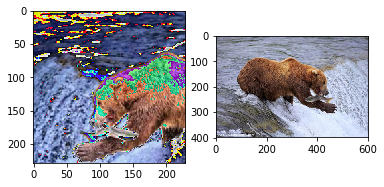

In [4]:
index = 50
annotation = image = full_dataset[index]['attributes']
image = full_dataset[index]['image']
image_no_process = full_dataset_no_process[index]['image']
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(transform_numpy(image))
f.add_subplot(1,2, 2)
plt.imshow(image_no_process)
plt.show(block=True)

In [5]:
checkpoint = torch.load('./focal_model_2_finetune_2c.chkpt', map_location='cpu')
classifier = AttributeClassifier(out_features=359, device='cpu')
classifier.load_state_dict(checkpoint['model'], strict=False)
predictor = AttributeClassifierInference(attribute_classifier=classifier, device='cpu')

In [6]:
pred = predictor(image.unsqueeze(0)).squeeze(0).detach().numpy()
ann = annotation.numpy()
print(pred)
print(ann)

num_correct_and_one = (ann == pred)
print(np.sum(num_correct_and_one), 'out of', len(ann))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [7]:
import torch.utils.data as d
data = d.DataLoader(full_dataset, batch_size=32, shuffle=True, drop_last=False, num_workers=2)

In [11]:
# Per attribute accuracy
total = 0
per_attribute = np.zeros_like(annotation.numpy())
for batch in tqdm(data, mininterval=2, desc='  - (Eval)   ', leave=False):
    x, y = batch['image'], batch['attributes']
    preds = predictor(x)
    correct_classes = y == preds
    total += correct_classes.shape[0]
    per_attribute += torch.sum(correct_classes, dim=0).numpy()
    if total > 500:
        break

per_attribute_statistics = per_attribute / total

  - (Eval)   :  10%|█         | 15/144 [01:04<09:12,  4.28s/it]

[0.9746094  0.9746094  0.98828125 0.9980469  0.96484375 0.9746094
 0.99609375 0.9980469  1.         0.99609375 0.9765625  1.
 0.9921875  0.9941406  0.9902344  0.99609375 1.         0.9921875
 1.         0.9902344  0.99609375 0.9980469  0.99609375 0.9746094
 0.9941406  0.9824219  0.9863281  1.         0.9941406  0.9921875
 0.9980469  0.9921875  0.9980469  0.9921875  0.9921875  1.
 1.         0.9902344  0.9902344  0.9941406  0.99609375 0.9921875
 0.9980469  0.99609375 0.9980469  0.9980469  0.9902344  0.9921875
 0.99609375 0.99609375 0.9941406  1.         0.9921875  0.99609375
 1.         1.         1.         0.99609375 0.9921875  0.9980469
 1.         0.9941406  0.9980469  1.         0.99609375 0.9980469
 0.9980469  0.9980469  0.9902344  0.9921875  0.9921875  0.98828125
 0.99609375 0.99609375 0.9941406  0.9902344  0.98828125 0.9941406
 0.9863281  0.9863281  0.99609375 0.9980469  0.99609375 0.9921875
 0.9921875  0.99609375 0.9902344  0.9980469  0.99609375 0.9921875
 0.9921875  0.99609375

In [13]:
print(per_attribute_statistics)

[0.9746094  0.9746094  0.98828125 0.9980469  0.96484375 0.9746094
 0.99609375 0.9980469  1.         0.99609375 0.9765625  1.
 0.9921875  0.9941406  0.9902344  0.99609375 1.         0.9921875
 1.         0.9902344  0.99609375 0.9980469  0.99609375 0.9746094
 0.9941406  0.9824219  0.9863281  1.         0.9941406  0.9921875
 0.9980469  0.9921875  0.9980469  0.9921875  0.9921875  1.
 1.         0.9902344  0.9902344  0.9941406  0.99609375 0.9921875
 0.9980469  0.99609375 0.9980469  0.9980469  0.9902344  0.9921875
 0.99609375 0.99609375 0.9941406  1.         0.9921875  0.99609375
 1.         1.         1.         0.99609375 0.9921875  0.9980469
 1.         0.9941406  0.9980469  1.         0.99609375 0.9980469
 0.9980469  0.9980469  0.9902344  0.9921875  0.9921875  0.98828125
 0.99609375 0.99609375 0.9941406  0.9902344  0.98828125 0.9941406
 0.9863281  0.9863281  0.99609375 0.9980469  0.99609375 0.9921875
 0.9921875  0.99609375 0.9902344  0.9980469  0.99609375 0.9921875
 0.9921875  0.99609375